<a href="https://colab.research.google.com/github/theouterlimitz/global-power-plant-database/blob/master/01_Global_Solar_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Power Plant Filter**

In [ ]:
import pandas as pd
import numpy as np

# --- Step 1: Load the Curated Dataset from Your First Project ---
print("Loading the global power plant dataset with water risk data...")
try:
    # This is the final output from your first capstone project
    df_all_plants = pd.read_pickle('analytical_data.pkl')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'analytical_data.pkl' not found. Please ensure the file from your first project is uploaded.")
    df_all_plants = pd.DataFrame()


# --- Step 2: Filter for Solar Power Plants ---
if not df_all_plants.empty:
    print("\nFiltering for solar power plants...")

    # Select rows where the 'primary_fuel' is 'Solar'
    df_solar = df_all_plants[df_all_plants['primary_fuel'] == 'Solar'].copy()

    print(f"Found {len(df_solar)} solar power plants in the global dataset.")


    # --- ** NEW STEP: Re-create the max_monthly_bws_score column ** ---
    print("\nCalculating annual maximum water stress score...")
    # Identify all the monthly baseline water stress SCORE columns
    bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]

    # Replace any potential error codes (-9999) with NaN before calculating the max
    df_solar[bws_score_cols] = df_solar[bws_score_cols].replace(-9999, np.nan)

    # For each power plant (row), find the maximum score it experiences across the 12 months
    df_solar['max_monthly_bws_score'] = df_solar[bws_score_cols].max(axis=1)


    # --- Step 3: Initial Inspection of the Solar-Only Dataset ---
    print("\n--- Overview of the Global Solar Plant Dataset ---")

    print("\nData Info:")
    df_solar.info(verbose=False)

    print("\nDescriptive Statistics for Key Columns:")
    # This line will now work correctly
    print(df_solar[['capacity_mw', 'max_monthly_bws_score']].describe())

else:
    print("Could not load data. Skipping analysis.")

**compare the distribution of water stress scores across the major primary fuel types**

--- Comparing Water Stress by Fuel Type ---
Calculating annual maximum water stress score for all plants...
Generating box plot...


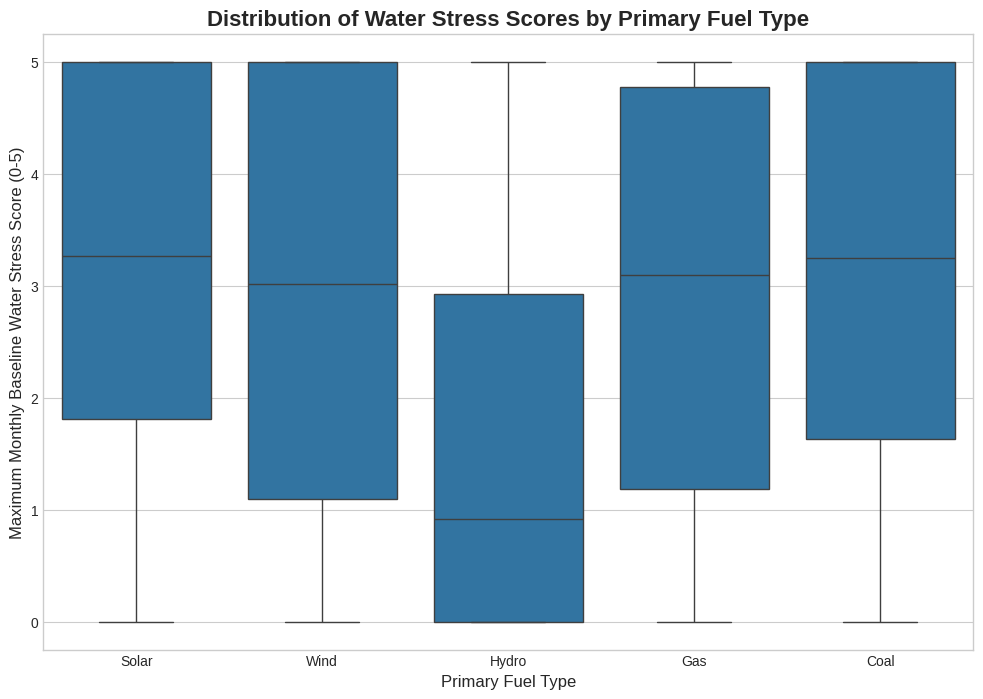

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume df_all_plants is still loaded in memory from the previous step ---
# If not, uncomment the line below to reload it.
# df_all_plants = pd.read_pickle('analytical_data.pkl')

# ===================================================================
# ---  Compare Water Stress Profiles Across Fuel Types ---
# ===================================================================
print("--- Comparing Water Stress by Fuel Type ---")

# 1. Ensure the max_monthly_bws_score column exists for all plants
if 'max_monthly_bws_score' not in df_all_plants.columns:
    print("Calculating annual maximum water stress score for all plants...")
    bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
    df_all_plants[bws_score_cols] = df_all_plants[bws_score_cols].replace(-9999, np.nan)
    df_all_plants['max_monthly_bws_score'] = df_all_plants[bws_score_cols].max(axis=1)

# 2. Filter for the major fuel types to keep the plot clean
major_fuels = ['Solar', 'Wind', 'Hydro', 'Gas', 'Coal']
df_major_fuels = df_all_plants[df_all_plants['primary_fuel'].isin(major_fuels)]

# 3. Create the box plot
print("Generating box plot...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

sns.boxplot(data=df_major_fuels,
            x='primary_fuel',
            y='max_monthly_bws_score',
            order=major_fuels) # Specify order for consistency

plt.title('Distribution of Water Stress Scores by Primary Fuel Type', fontsize=16, fontweight='bold')
plt.xlabel('Primary Fuel Type', fontsize=12)
plt.ylabel('Maximum Monthly Baseline Water Stress Score (0-5)', fontsize=12)
plt.show()

**Where are these high-risk solar plants concentrated**

--- Creating a global map of water stress for SOLAR plants ---
Mapping 10589 solar plants with valid data.


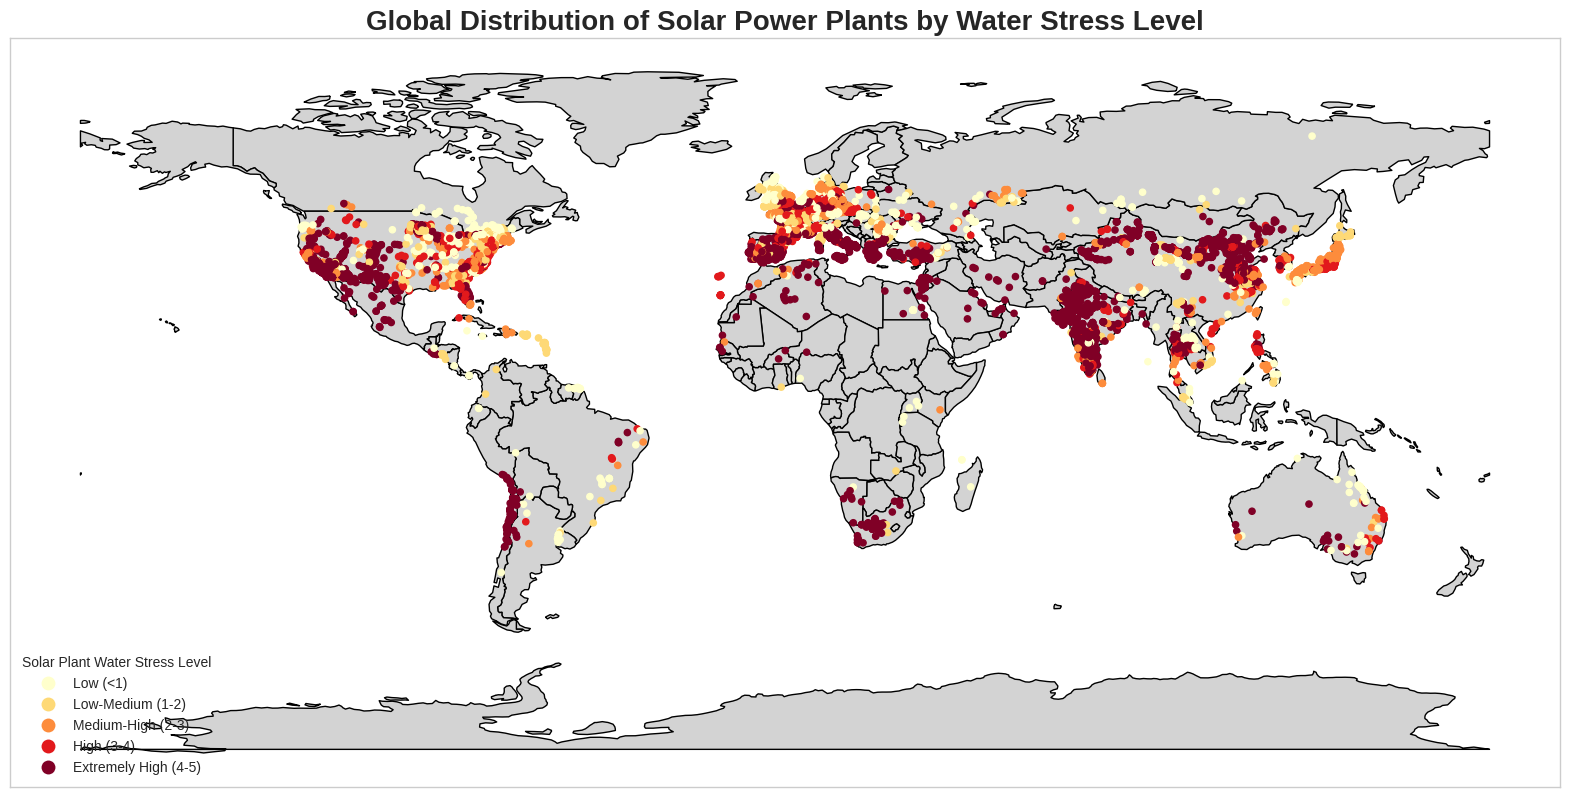

In [6]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Assume df_all_plants is still loaded in memory ---
# If not, uncomment the line below to reload it.
# df_all_plants = pd.read_pickle('analytical_data.pkl')

# ===================================================================
# ---  Create a World Map of Solar Plant Water Stress ---
# ===================================================================
print("--- Creating a global map of water stress for SOLAR plants ---")

# 1. Ensure the risk score and label columns exist for all plants
if 'max_monthly_bws_score' not in df_all_plants.columns:
    print("Calculating annual maximum water stress score for all plants...")
    bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
    df_all_plants[bws_score_cols] = df_all_plants[bws_score_cols].replace(-9999, np.nan)
    df_all_plants['max_monthly_bws_score'] = df_all_plants[bws_score_cols].max(axis=1)

if 'annual_bws_label' not in df_all_plants.columns:
    score_bins = [-1, 1, 2, 3, 4, 5.1]
    score_labels = ['Low (<1)', 'Low-Medium (1-2)', 'Medium-High (2-3)', 'High (3-4)', 'Extremely High (4-5)']
    df_all_plants['annual_bws_label'] = pd.cut(df_all_plants['max_monthly_bws_score'], bins=score_bins, labels=score_labels)


# 2. Filter for just Solar plants and drop any without location or risk data
df_solar = df_all_plants[df_all_plants['primary_fuel'] == 'Solar'].copy()
df_solar_for_map = df_solar.dropna(subset=['geometry', 'annual_bws_label'])
print(f"Mapping {len(df_solar_for_map)} solar plants with valid data.")


# 3. Create the World Map
# ** THE FIX IS HERE: Load the map from a new, reliable URL. **
try:
    # This URL points to a GeoJSON file of world countries used in many examples and is more stable.
    world_url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json"
    world = gpd.read_file(world_url)

    fig, ax = plt.subplots(figsize=(20, 12))

    # Plot the base world map
    world.plot(ax=ax, color='lightgray', edgecolor='black')

    # Plot the solar plant data points on top
    df_solar_for_map.plot(ax=ax,
                          column='annual_bws_label',
                          categorical=True,
                          legend=True,
                          markersize=20,
                          cmap='YlOrRd',
                          legend_kwds={'title': "Solar Plant Water Stress Level", 'loc': 'lower left'})

    ax.set_title('Global Distribution of Solar Power Plants by Water Stress Level', fontsize=20, fontweight='bold')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

except Exception as e:
    print(f"An error occurred while creating the map: {e}")